In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import networkx as nx
import cvxpy as cp
import math
from tqdm import tqdm, trange

# Networked Distributed Optimization with Exogenous Inputs
Consider an $n$-player network game defined on graph structure $\mathcal{G}=(\mathcal{N},\mathcal{E})$, where $\mathcal{N}=\{1,\ldots,n\}$ are the nodes in the graph---one corresponding to each player---and $$\mathcal{E}=\{(i,j)|\ i,j\in \mathcal{N} \ \text{such that}\ i\  \text{is connected to } j\},$$
is the set of edges.

Each player $i\in \mathcal{N}$ collects data and has objective $F_i(x, \xi_i, \xi)$ where $\xi_i\in \Xi_i$ is a random variable with fixed but unknown probability distribution with domain $\Xi_i$ and similarly, $\xi$ is a random variable with fixed but unknown probability distribution with domain $\Xi$. The random variable $\xi_i$ models local environmental fluctuations such as noise. The random variable $\xi$, on the other hand, models a global information state.

In this simulation, we consider a simple Bertrand competition where the players cooperatively seek the social optimum. Each individual has a demand function $D_i(x_i,x_{-i},\xi)$ which is a nonincreasing function of the prices $x_i$ and $x_{-i}$. Each player obtains a revenue $F_i$ where
$$f_i(x_i,x_{-i},\xi) = x_i\cdot D_i(x_i,x_{-i},\xi).$$

Here, we consider a linear demand function where $\xi$ determines the base demand and the price elasticities with respect to each price $x_i$ are given by a vector $\theta\in\mathbb{R}^n$:
$$D_i(x_i,x_{-i},\xi) = \xi + \theta_i^\top x$$

# Problem Parameters

In [2]:
n = 50  # Number of nodes
np.random.seed(37)
theta_0 = (1/(n+3))*np.ones((n,n))-2*np.eye(n)
theta = theta_0 + 0.1*np.random.randn(n,n)
xi_bar = n

# Loss and Gradient Oracles

In [3]:
def demand(x,theta,xi):  # calculate demand
    return np.dot(theta,x) + xi

def revenue(x,theta,xi):  # calculate revenue
    return x*demand(x,theta,xi)

def total_revenue(x,theta,xi):  # calculate social revenue
    return np.sum(revenue(x,theta,xi))

def grad_revenue(x,theta,xi):  # gradients wrt individual revenues
    return np.dot(theta+theta.T,x) + xi

# CVXPY solution

In [4]:
theta_s = 0.5*(theta+theta.T)
x = cp.Variable(n)
objective = cp.Maximize(cp.quad_form(x,theta_s)+(xi_bar*np.ones(n)@x))
constraints = [0 <= x, x <= n]
prob = cp.Problem(objective, constraints)

revenue_so = prob.solve()

x_so = x.value
print(x_so.round(2))
print(f'socially optimal total revenue: ${revenue_so.round(2)}')

[23.92 33.78 32.65 21.18 25.56 28.15  7.6  41.87 29.8  29.58 27.76 28.25
 25.39 30.88 29.06 12.28 37.77 36.11 22.87 18.67 35.39 10.88 32.24 33.81
 20.55 26.17 21.94 22.59 35.71 38.55 21.46 27.7  33.84 25.41 21.8   6.37
 38.23 31.17 41.23 19.28 27.7  25.88 22.18 17.9  33.94 25.23 28.21 18.3
 25.27 24.09]
socially optimal total revenue: $33403.0


# Optimization Parameters

In [5]:
step = 1e-2
alpha = 1-1e-3
p_max = n
window = 1
delta = 1e-0
trials = 100

# Distributed SGD with asynchronous information

In [6]:
np.random.seed(37)
avg_iterations = []

for n_i in range(1,n):
    for trial in trange(trials):
        N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
        N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
        N[N_i] = True  # Set informed node indices to True (informed)

        G = nx.random_tree(n)  # Generate graph from the nodes in N

        attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
        for node in G.nodes:
            attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  

        nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

        l_tr = np.sort(nx.laplacian_spectrum(G))[1]

        P = nx.laplacian_matrix(G).toarray()
        P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

        X = np.random.rand(n,n)

        x_dist_hist = []
        x_bar_hist = []
        iter_count = 0
        xerr = 1e9
        stop_iter = []

        while xerr>delta:
            xi = n+np.random.randn(1)
            for node in range(n):
                if G.nodes[node]['informed']:
                    G.nodes[node]['xi'] = xi
                else:
                    xi_lst = []
                    for neig in G.neighbors(node):
                        xi_lst.append(G.nodes[neig]['xi'])
                    G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
            x_dist_hist.append(np.mean(X.copy(),axis=0))
            ma_len = min(window,len(x_dist_hist))
            xerr = la.norm(x_so - np.mean(x_dist_hist[-ma_len:],axis=0))**2
            X = np.dot(P,X)
            for j in range(n):
                xi_j = G.nodes[j]['xi']
                X[j] += (step*(alpha**iter_count))*grad_revenue(X[j],theta,xi_j)
            X = np.clip(X,0,p_max)
            iter_count +=1
        stop_iter.append(iter_count)
    avg_iter = np.mean(stop_iter)
    avg_iterations.append(avg_iter)

100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]


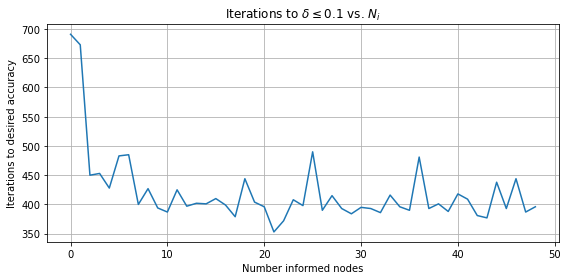

In [8]:
plt.figure(figsize=(8,4))
plt.plot(avg_iterations)
plt.title(r'Iterations to $\delta\leq 0.1$ vs. $N_i$')
plt.xlabel('Number informed nodes')
plt.ylabel('Iterations to desired accuracy')
plt.grid()
plt.tight_layout()
plt.savefig('./figures/iterations_vs_ni.png')
plt.show()